In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/cell-images-for-detecting-malaria"))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['cell_images']


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,Activation,AveragePooling2D

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121

from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras import regularizers
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Using TensorFlow backend.


**Importing Data****

In [3]:
parasitized_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/')
uninfected_data = os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/')

In [6]:
from skimage import transform
import cv2
imageSize = (50,50,3)
train_dir = '../input/cell-images-for-detecting-malaria/cell_images/cell_images/' # This folder contains 10.000 images and 3 subfolders , each folder contains different number of images

from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in   ['Parasitized']:
                label = 1
            elif folderName in ['Uninfected']:
                label = 0
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (50, 50))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X) # Keras only accepts data as numpy arrays 
    y = np.asarray(y)
    return X,y
X, y= get_data(train_dir)

100%|██████████| 13780/13780 [01:24<00:00, 162.84it/s]


***Showing Cell Image at Index 0***

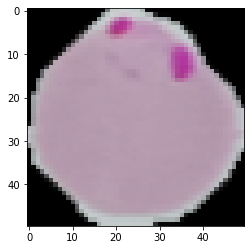

In [7]:
plt.imshow(X[0])
plt.show()

In [8]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
image_data = X[idx]
labels = y[idx]

Spliting Data for Training and Testing

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

**Converting y_train and y_test in Categorical form(used for converting labels to one-hot-encoding) **

In [10]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [11]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train,y_train,test_size = 0.1)

**Building Model (DenseNet121)**

In [19]:
input_shape = (50,50,3)
n_classes = 2
n_model = DenseNet121(weights='imagenet',input_tensor=None, include_top=False, input_shape=input_shape)
model = Sequential()
model.add(n_model)
model.add(AveragePooling2D(pool_size=(1,1), name='avg_pool'))
model.add(Flatten())
model.add(Dense(1024, activation='relu', name='dense_post_pool'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid', name='predictions'))
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_post_pool (Dense)      (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 8,089,154
Trainable params: 8,005,506
Non

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','mae'])

**Monitoring learning Rate**

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='lr',  
                                            factor=0.5, 
                                            min_lr=0.0001)

In [22]:
epochs = 10 
batch_size = 200
history = model.fit(x_train,y_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    callbacks=[learning_rate_reduction]
)

Train on 19841 samples, validate on 2205 samples
Epoch 1/10
19841/19841 [==============================] - 86s 4ms/step - loss: 0.4695 - accuracy: 0.6972 - mae: 0.3157 - val_loss: 0.6457 - val_accuracy: 0.4866 - val_mae: 0.2929
Epoch 2/10
19841/19841 [==============================] - 25s 1ms/step - loss: 0.2803 - accuracy: 0.8807 - mae: 0.1831 - val_loss: 0.7570 - val_accuracy: 0.9025 - val_mae: 0.0980
Epoch 3/10
19841/19841 [==============================] - 26s 1ms/step - loss: 0.1082 - accuracy: 0.9625 - mae: 0.0584 - val_loss: 0.3687 - val_accuracy: 0.8522 - val_mae: 0.1883
Epoch 4/10
19841/19841 [==============================] - 26s 1ms/step - loss: 0.0986 - accuracy: 0.9654 - mae: 0.0545 - val_loss: 0.3294 - val_accuracy: 0.9243 - val_mae: 0.0881
Epoch 5/10
19841/19841 [==============================] - 25s 1ms/step - loss: 0.0800 - accuracy: 0.9722 - mae: 0.0440 - val_loss: 0.1428 - val_accuracy: 0.9510 - val_mae: 0.0615
Epoch 6/10
19841/19841 [==============================] 

In [23]:
loss, acc, mae = model.evaluate(x_test, y_test)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}\nThe Mean Absolute Error in the model is {:.3f}".format(acc,loss,mae))

5512/5512 [==============================] - 6s 1ms/step
The accuracy of the model is 0.957
The Loss in the model is 0.169
The Mean Absolute Error in the model is 0.051


**Model Graph**

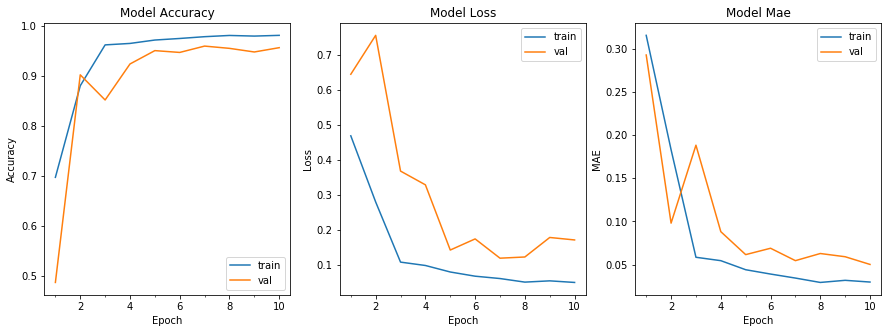

In [24]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    #summarize History for MAE
    axs[2].plot(range(1,len(model_history.history['mae'])+1),model_history.history['mae'])
    axs[2].plot(range(1,len(model_history.history['val_mae'])+1),model_history.history['val_mae'])
    axs[2].set_title('Model Mae')
    axs[2].set_ylabel('MAE')
    axs[2].set_xlabel('Epoch')
    axs[2].set_xticks(np.arange(1,len(model_history.history['mae'])+1),len(model_history.history['mae'])/10)
    axs[2].legend(['train', 'val'], loc='best')
    plt.show()
plot_model_history(history)

**Confusion Matrix**

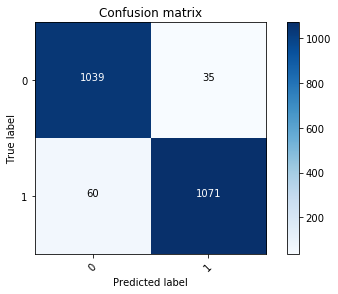

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

**Classification Report**

In [26]:
report = classification_report(Y_true, Y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1074
           1       0.97      0.95      0.96      1131

    accuracy                           0.96      2205
   macro avg       0.96      0.96      0.96      2205
weighted avg       0.96      0.96      0.96      2205

